### Image Captioning
UNI: pc3019 <br>
By: Preethi Chandirasekeran <br> <br>

Another objective of this project was to perform image captioning of the book cover images. The image captioning model was trained using the Flickr8K dataset. It is a dataset of 8,000 images where each image is mapped to 5 captions which describe the content of the image. The image embedding was implemented using Inception v3 which is a model pretrained on ImageNet. It accepts an input shape of 299x299x3 and creates an embedding vector of dimensions 256x1. <br>
The captions from the dataset are preprocessed before passing to the RNNs. Text preprocessing includes converting to lowercase, removing special characters, and more. “startseq” is added to the beginning of each caption. Similarly, “endseq” is added to the end of each caption. <br><br>
The word embedding technique used is GloVe. GloVe is an unsupervised learning algorithm to obtain the word vector representations. The GloVe embedding representation used in this project has 6 billion tokens and 200 features. To obtain the predicted image caption, the image is passed to the model with the input string “startseq”. Then the model predicts the next word and this word is appended to the input string. This repeats until “endseq” is reached or the maximum sentence length is reached. 

In [81]:
from time import time
import os
import glob
from tqdm import tqdm
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import string
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from pickle import dump,load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input,Dense,LSTM,Dropout,Embedding
from tensorflow.keras.utils import plot_model

In [82]:
os.listdir('../input/flickr8k')

['captions.txt', 'Images']

In [83]:
my_images = glob.glob('../input/flickr8k/Images/' +'*.jpg')


In [84]:
# Defining utility function which is used to load captions.txt
def loadFileUtil(file_name):
    f = open(file_name,'r')
    content = f.read()
    f.close()
    return content

captions = loadFileUtil('../input/flickr8k/captions.txt')
captions = captions.split('\n')


In [85]:

captions.pop(0)


'image,caption'

In [86]:
captions.pop(-1)

''

In [87]:
# Formatting the captions
my_images = []
for x in range(len(captions)):
    curr_img = captions[x].split(',')
    curr_img = curr_img[0]
    my_images.append(curr_img)
    
my_images= set(my_images)


In [88]:
# Populating a dictionary where the image name is the key and captions are the value
imgNameDict = {}
for curr_img in my_images:
    imgNameDict[curr_img] = []

for curr_image_caption in captions:
    curr_image_caption = curr_image_caption.split(',')
    curr_img,mycap = curr_image_caption[0],curr_image_caption[-1]
    imgNameDict[curr_img].append(mycap)

In [89]:
# Creating a translation table for punctuation removal
mytable = str.maketrans('', '', string.punctuation)


In [90]:
for curr_img,captionList in imgNameDict.items():
    for x,curr_cap in enumerate(captionList):
        curr_cap = curr_cap.split()
      
        curr_cap = [y.lower() for y in curr_cap]
       
        curr_cap = [y.translate(mytable) for y in curr_cap]
      
        curr_cap = [y for y in curr_cap if len(y) >1]
 
        curr_cap = [y for y in curr_cap if y.isalpha()]

        captionList[x] = ' '.join(curr_cap)

In [91]:
# Defining function to save the caption data
def saveCaptionData(caps,file_name):
    lines = []
    for img,capList in caps.items():
        for curr_cap in capList:
            lines.append(img + ',' + curr_cap)
        content = '\n'.join(lines)
        f =  open(file_name,'w')
        f.write(content)
        f.close()

    


In [92]:
# Saving the cleaned captions
saveCaptionData(imgNameDict,'./cleanedCaptionData.txt')

In [93]:
# Defining function to load the caption data
def loadCaptionData(file_name,image_path):
    myfile = loadFileUtil(file_name)
    myImageDict = {} 
    my_images = glob.glob(image_path +'*.jpg')
    for idx,curr_image in enumerate(my_images):
        curr_image = curr_image.split('/')[-1]
        my_images[idx] = curr_image
        myImageDict[curr_image] = []  
    for line in myfile.split('\n'):
        tokens = line.split(',')
        my_image= tokens[0]
        curr_cap=tokens[1:]
        if my_image in my_images:
            curr_cap = 'startseq ' + ' '.join(curr_cap) + ' endseq'
            myImageDict[my_image].append(curr_cap)
    return myImageDict

# Loading the cleaned caption data
imgNameDict = loadCaptionData('./cleanedCaptionData.txt','../input/flickr8k/Images/')

In [94]:
# Defining utility function to preprocess the image 
def preprocessingUtil(myPath):
    curr_img = image.load_img(myPath,target_size=  (299,299))
    temp= image.img_to_array(curr_img)
    temp = np.expand_dims(temp,axis =0) 
    temp = preprocess_input(temp) 
    return temp

startseq people walk outside on wooden walkway endseq
startseq three woman walk on the sidewalk endseq
startseq two elderly women are walking past younger woman on public path endseq
startseq walkers on concrete boardwalk under blue sky endseq
startseq women walking beneath blue sky and powerlines endseq


Text(0.5, 1.0, '824123145_59243e504e.jpg')

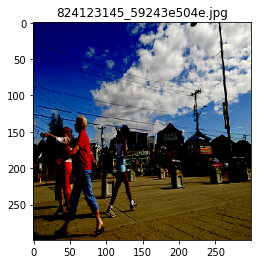

In [95]:

random_image = random.choice(list(my_images))
temp2  = preprocessingUtil('../input/flickr8k/Images/' + random_image)
for cap in imgNameDict[random_image]:
    print(cap)
plt.imshow(temp2[0])
plt.title(random_image)

In [96]:
# Loading the InceptionV3 model
mymodel = InceptionV3(weights = 'imagenet')

In [97]:
# Removing the last layer
featExtractor = Model(mymodel.input,mymodel.layers[-2].output) 
featExtractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [98]:
# Performing image embedding with featExtractor
def encodeData(curr_image,featExtractor):
    curr_image = preprocessingUtil(curr_image) 
    featVector = featExtractor.predict(curr_image) 
    featVector = np.ravel(featVector) 
    return featVector



In [108]:
# Dividing the data into training, validation, and testing data
AllData = list(my_images)
trainingData = AllData[:6000]
validationData = AllData[6000:7000]
TestingData = AllData[7000:]
print(f'Number of training images {len(trainingData)}')
print(f'Number of testing images {len(TestingData)}')
print(f'Number of validation images {len(validationData)}')


Number of training images 6000
Number of testing images 1091
Number of validation images 1000


In [109]:
trainingEnc = {}
validationEnc = {}
testingEnc = {}


In [110]:
# Encoding the training data
for x in range(1,len(trainingData)):
    myloc = '../input/flickr8k/Images/' + trainingData[x]
    trainingEnc[trainingData[x]] = encodeData(myloc,featExtractor)

In [111]:
# Storing the encoded training images
with open('./training_images_enc.pkl','wb') as pickEnc:
    dump(trainingEnc,pickEnc)

In [112]:
# Similarly we encode and store the validation and testing data
for curr_img in tqdm(validationData):
    validationEnc[curr_img] = encodeData('../input/flickr8k/Images/' + curr_img,featExtractor)

100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s]


In [113]:
with open('./validation_images_enc.pkl','wb') as pickEnc:
    dump(validationEnc,pickEnc)

In [114]:

for curr_img in tqdm(TestingData):
    testingEnc[curr_img] = encodeData('../input/flickr8k/Images/' + curr_img,featExtractor)


100%|██████████| 1091/1091 [01:12<00:00, 15.00it/s]


In [115]:
with open('./testing_images_enc.pkl','wb') as pickEnc:
    dump(testingEnc,pickEnc)

In [116]:
!cp ./testing_images_enc.pkl /content/drive/MyDrive

cp: cannot create regular file '/content/drive/MyDrive': No such file or directory


In [117]:
# Loading the features
featTrain = load(open('./training_images_enc.pkl','rb'))

featValid = load(open('./validation_images_enc.pkl','rb'))

featTest = load(open('./testing_images_enc.pkl','rb'))
print(f'The number of training features {len(featTrain)}')
print(f'The number of testing features {len(featTest)}')
print(f'The number of validation features {len(featValid)}')

The number of training features 5999
The number of testing features 1091
The number of validation features 1000


In [118]:
# Creating separate lists for storing the training, testing, and validation captions
allCaptionsTrain = []
allCaptionsVal = []
allCaptionsTest = []
for x in range(1,len(trainingData)):
    curr_img=trainingData[x]
    captions = imgNameDict[curr_img]
    for mycap in captions:
        allCaptionsTrain.append(mycap)
print(f'Number of all training captions {len(allCaptionsTrain)}')

Number of all training captions 29995


In [119]:

for curr_img in validationData:
    captions = imgNameDict[curr_img]
    for mycap in captions:
        allCaptionsVal.append(mycap)
print(f'Number of all validation captions {len(allCaptionsVal)}')

Number of all validation captions 5000


In [120]:

for img in TestingData:
    captions = imgNameDict[img]
    for mycap in captions:
        allCaptionsTest.append(mycap)
print(f'Number of all test captions {len(allCaptionsTest)}')

Number of all test captions 5455


In [121]:
wc = {}
for mysentence in allCaptionsTrain:
    for curr_word in mysentence.split(' '):
        wc[curr_word] = wc.get(curr_word,0) + 1  

myvocab = [curr_word for curr_word in wc if wc[curr_word] >= 10]


In [122]:
id_word = {} 
word_id = {} 
idx = 1
for curr_word in myvocab:
    word_id[curr_word] = idx
    id_word[idx] = curr_word 
    idx +=1

In [123]:
with open('./word_id.pkl','wb') as word_id1:
    dump(word_id,word_id1)

In [124]:
with open('./id_word.pkl','wb') as id_word1:
    dump(id_word,id_word1)

In [125]:
vocabSize = len(id_word) +1 
vocabSize

1621

In [126]:
trainDict = {}
for x in range(1,len(trainingData)):
    my_image=trainingData[x]
    trainDict[my_image] = imgNameDict[my_image]

In [127]:


# Defining function to find maximum length of captions
def maxFun(imageCaptions):
    lines = to_lines(imageCaptions)
    return max(len(line.split()) for line in lines) 

# Defining function which accepts dictionary of clean captions as input
# Returns captions list
def to_lines(imageCaptions):
    allCaptions = []
    for x in imageCaptions.keys():
        [allCaptions.append(mycap) for mycap in imageCaptions[x]]
    return allCaptions

maxLength = maxFun(trainDict)
print(f'The captions maximum length is {maxLength}')

The captions maximum length is 30


In [128]:
# Loading GloVe
embeddingsIndex = {} 
myfile = open('../input/glove6b/glove.6B.200d.txt',encoding = 'utf-8')

for x in tqdm(myfile):
    vals = x.split() 
    curr_word = vals[0]
    coefficients = np.asarray(vals[1:],dtype = 'float32')
    embeddingsIndex[curr_word] = coefficients 

myfile.close()
print('Number of word vectors is %s' % len(embeddingsIndex))

400000it [00:18, 21609.09it/s]

Number of word vectors is 400000


In [129]:
embedDim = 200

In [130]:
# Creating the embedding matrix
embedMat = np.zeros((vocabSize,embedDim)) 
print(f'The embedding matrix dimensions are {embedMat.shape}') 

The embedding matrix dimensions are (1621, 200)


In [131]:
for curr_word,idx in word_id.items():
    embedVec = embeddingsIndex.get(curr_word)
    if embedVec is not None:
        embedMat[idx] = embedVec

In [132]:
# Building the model
inp1 = Input(shape = (2048,))
fe1 = Dropout(0.5)(inp1)
fe2 = Dense(256,activation = 'relu')(fe1)
inp2 = Input(shape = (maxLength,))
se1 = Embedding(vocabSize,embedDim,mask_zero = True)(inp2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
dec1 = add([fe2,se3])
dec2 = Dense(256,activation = 'relu')(dec1)
out = Dense(vocabSize,activation = 'softmax')(dec2)


In [133]:
mymodel2 = Model(inputs = [inp1,inp2],outputs = out)
mymodel2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      324200      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

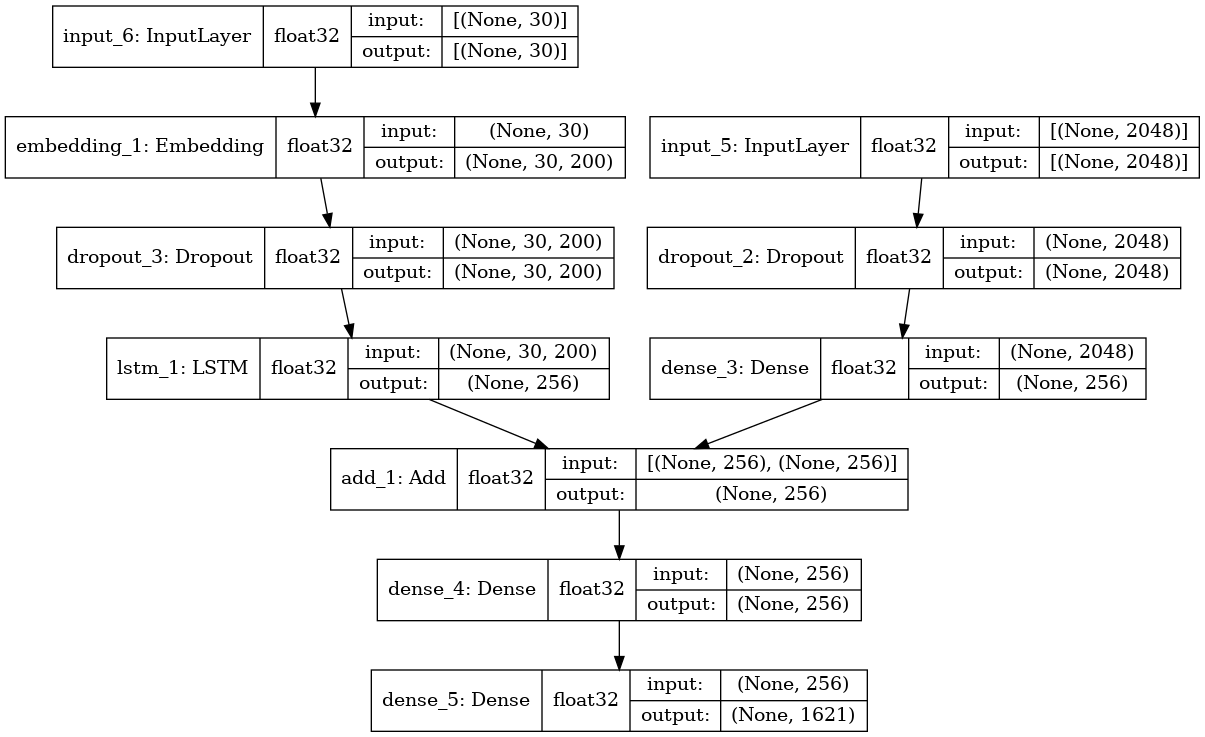

In [134]:
# Displaying the model layers
plot_model(mymodel2,
           to_file='mymodel2.png',
           show_layer_names=True,
           show_dtype=True,
           show_shapes=True
           )

In [135]:
print(f'Embedding Matrix Shape {embedMat.shape}')
embedWeight = mymodel2.layers[2].get_weights()
print(f'Embedding Weight Shape {embedWeight[0].shape}') 
mymodel2.layers[2].set_weights([embedMat])
mymodel2.layers[2].trainable = False


Embedding Matrix Shape (1621, 200)
Embedding Weight Shape (1621, 200)


In [136]:
mymodel2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      324200      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [137]:
mymodel2.compile(optimizer = 'adam',loss = 'categorical_crossentropy')

In [138]:

epochs = 10
steps = len(trainDict)//6

mymodel2.optimizer.lr = 1e-4


In [139]:

def data_generator(trainDict,featTrain,word_id,maxLength,pics_p_batch):
    y=[]
    n = 0 
    X1 =[]
    X2=[]
    
    while True:
        for curr_image,captionsList in trainDict.items():
            n+=1
            myfeatVect = featTrain[curr_image]
            for mycap in captionsList:
                encoded_cap = [word_id[word] for word in mycap.split(' ') if word in word_id]
                for idx in range(1,len(encoded_cap)): 
                    in_seq = encoded_cap[:idx]
                    out_seq = encoded_cap[idx]
                    in_seq = pad_sequences([in_seq],maxlen = maxLength)[0] 
                    out_seq = to_categorical([out_seq],num_classes = vocabSize)[0] 
                    y.append(out_seq) 
                    X1.append(myfeatVect)
                    X2.append(in_seq) 
                    
            if n == pics_p_batch:
                X1,X2,y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                y=[]
                n=0
                X1 =[]
                X2=[]
                

In [140]:
'3448855727_f16dea7b03.jpg' in featTrain

True

In [141]:
for curr_epoch in range(epochs):
    genvar = data_generator(trainDict, featTrain, word_id, maxLength, 6)
    mymodel2.fit_generator(genvar, epochs=1, steps_per_epoch=steps, verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


999/999 [==============================] - 115s 115ms/step - loss: 3.3863


In [142]:
# Saving the model
mymodel2.save('model_flickr8k')

# Saving the model weights
mymodel2.save_weights('./model_flickr8k.h5')

In [143]:
!zip -r model_flickr8k.zip model_flickr8k

updating: model_flickr8k/ (stored 0%)
updating: model_flickr8k/saved_model.pb (deflated 90%)
updating: model_flickr8k/variables/ (stored 0%)
updating: model_flickr8k/variables/variables.data-00000-of-00001 (deflated 7%)
updating: model_flickr8k/variables/variables.index (deflated 64%)
updating: model_flickr8k/assets/ (stored 0%)


In [144]:
#To obtain the predicted image caption, the image is passed to the model with the input string “startseq”. 
# Then the model predicts the next word and this word is appended to the input string. This repeats until 
# “endseq” is reached or the maximum sentence length is reached.

def greedy_search(featVect,verbose = 0):
    in_text ='startseq'
    for i in range(maxLength):
        sequence = [word_id[x] for x in in_text.split() if x in word_id]
        sequence = pad_sequences([sequence],maxlen = maxLength)
        yhat = mymodel2.predict([featVect,sequence],verbose = verbose) # [(1,2048),(1,31)]
        yhat = np.argmax(yhat) 
        curr_word = id_word[yhat] 
        in_text += ' ' + curr_word
        if curr_word == 'endseq':
            break
    res = in_text.split()
    res = res[1:-1] 
    res = ' '.join(res) 
    return res


img = random.choice(TestingData) 
featVect = featTest[img].reshape((1,2048))
print(f'feature_vector: {featVect.shape}')
final = greedy_search(featVect,1)
final

feature_vector: (1, 2048)
1/1 [==============================] - 0s 23ms/step


'woman wearing red shirt and glasses and glasses'

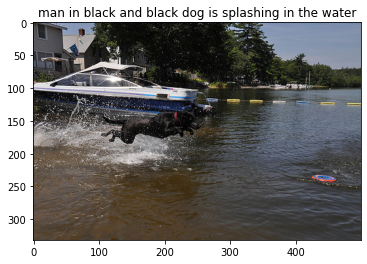

In [145]:

img = random.choice(TestingData) 
feature_vector = featTest[img].reshape((1,2048))
x = plt.imread('../input/flickr8k/Images/' + img)
plt.imshow(x)
plt.title(greedy_search(feature_vector,0))
plt.show()

In [146]:
# Performing image captioning for a single sample image from the dataset
img = 'fantasy20.jpg'
testingEnc[img] = encodeData('../input/sampleimage/' + img,featExtractor)

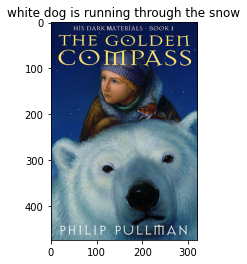

In [147]:

feature_vector = testingEnc[img].reshape((1,2048))
x = plt.imread('../input/sampleimage/fantasy20.jpg')
plt.imshow(x)
plt.title(greedy_search(feature_vector,0))
plt.show()

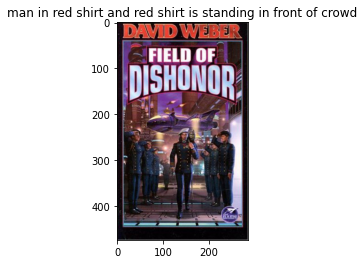

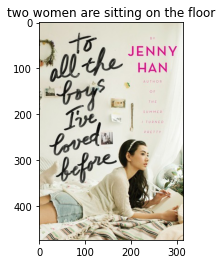

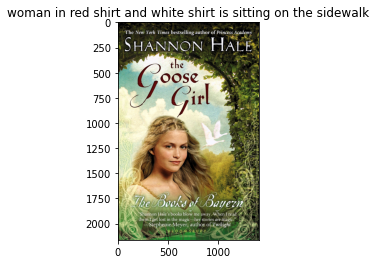

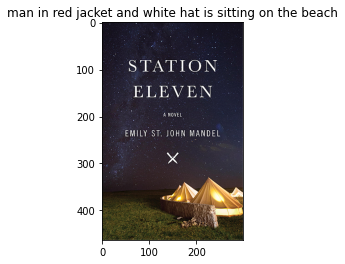

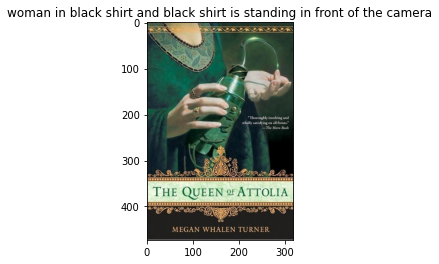

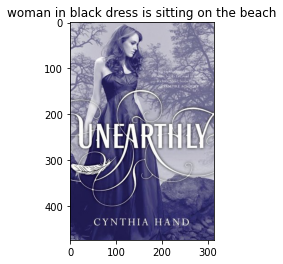

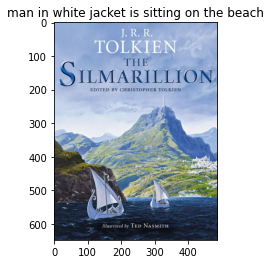

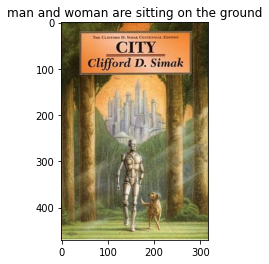

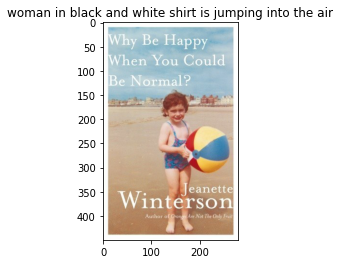

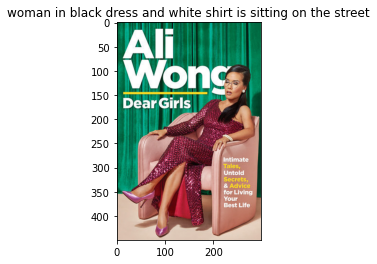

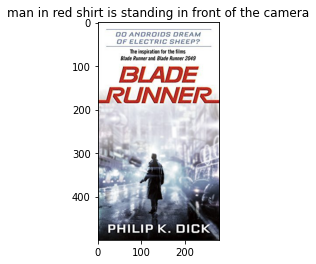

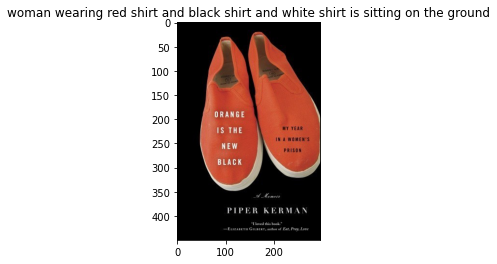

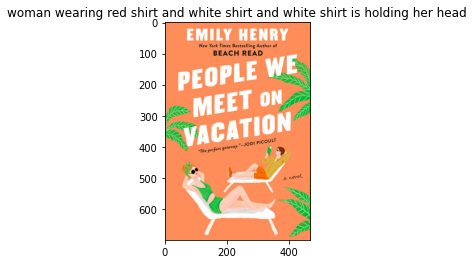

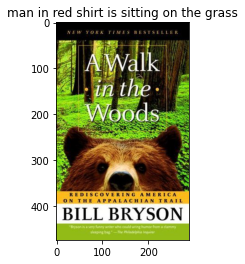

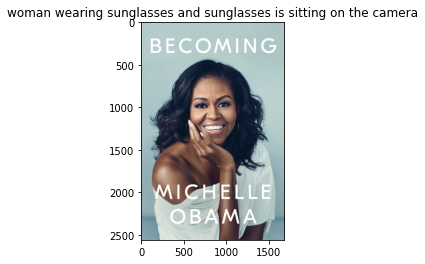

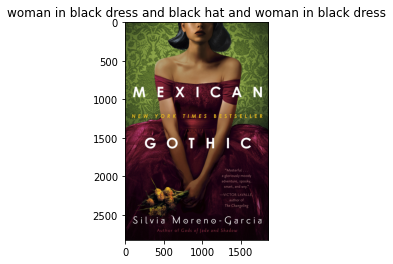

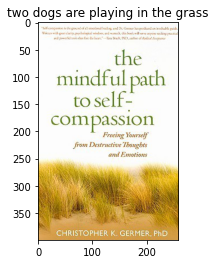

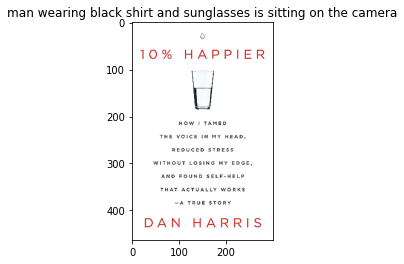

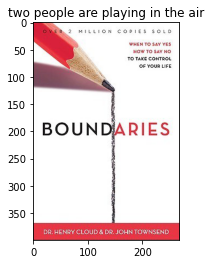

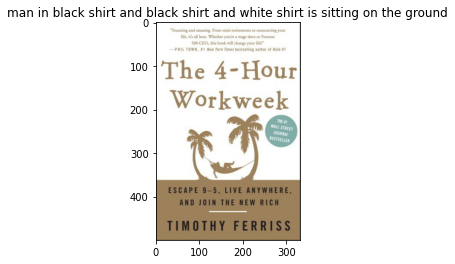

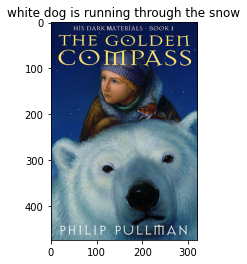

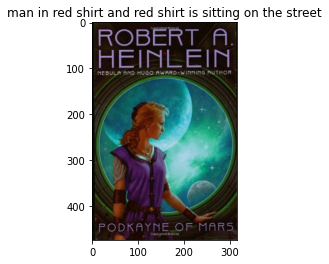

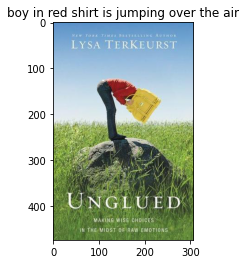

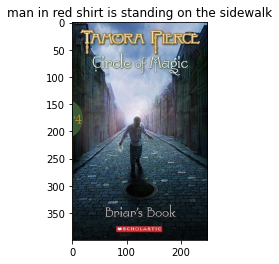

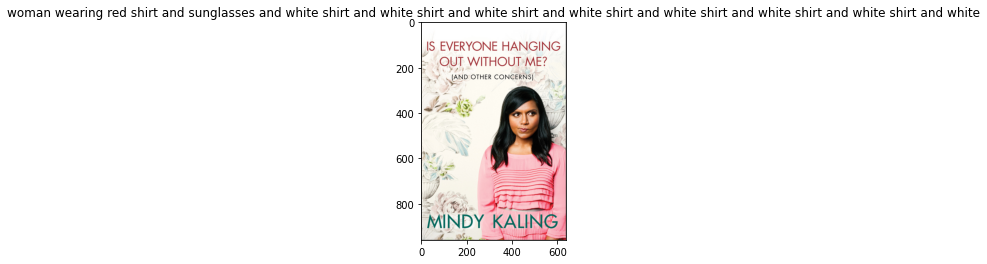

In [148]:
# Performing image captioning for several sample images from the dataset
for myfile in os.listdir('../input/sampleimage/'):
    img = myfile
    encoded_data = encodeData('../input/sampleimage/' + img,featExtractor)
    feature_vector = encoded_data.reshape((1,2048))
    x = plt.imread('../input/sampleimage/'+img)
    plt.imshow(x)
    plt.title(greedy_search(feature_vector,0))
    plt.show()